# Automated Detection of Internally Displaced Person (IDP) Shelters

### Setup Arguments and Environment

In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt

In [3]:
import os

# get repo root path
cwd = os.getcwd() 
repo = 'idp-master'

root_path = cwd [ : cwd.find( repo ) + len( repo ) ]
print ( root_path )

C:\Users\KaziMomin.Ashraf\OneDrive - Satellite Applications Catapult\Documents\GitHub\idp-master


In [15]:
# add to system path
import sys
sys.path.insert(0,root_path)

In [16]:
# set up args
import glob
#insert 
image_pathname = 'D:\catapult_stuff\data\G4\G4_compy.tif'
centroid_pathname = 'D:\catapult_stuff\data\G4\centroids\centroids.shp' 
output = 'D:/catapult_stuff/data/G4/output_test/structure.shp'

### Open and Visualise Image and Centroid Datasets

In [17]:
# import centroid2footprint class
from src.morph.extractor import FootprintExtractor
obj = FootprintExtractor()

# open centroid shape file
centroid = obj.openCentroidFile( centroid_pathname )

# open image
image = obj.openImageFile( image_pathname, band_index=1 )  

# convert centroid locations to top left image aoi coordinates
coords = obj.getCentroidImageCoordinates( centroid, image )

<IPython.core.display.Javascript object>


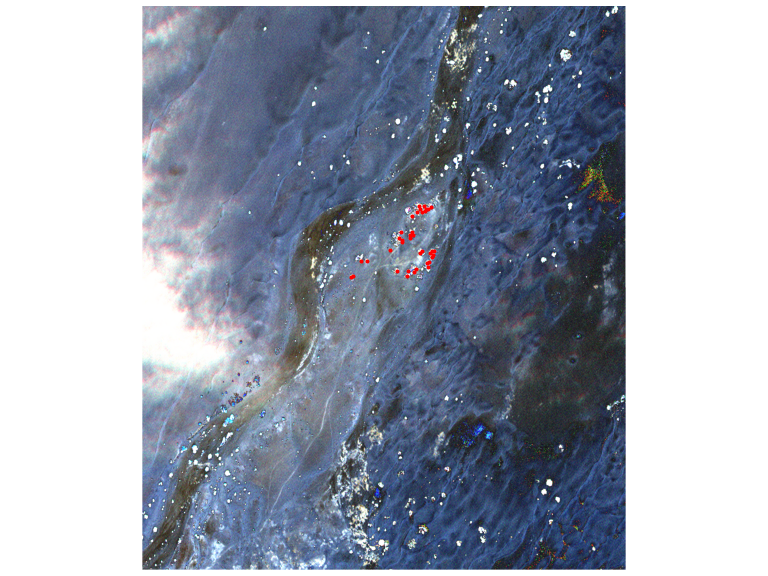

In [18]:
import gdal
import numpy as np

# create figure
fig = plt.figure()

# read image
ds = gdal.Open( image_pathname )
data = ds.ReadAsArray()
data = np.transpose( data, ( 1, 2, 0 ) )

# rescale 16bit to 8bit
for idx in range( ds.RasterCount ):
    r = np.percentile( data[ :,:,idx ], [ 2, 98 ] )
    data[ :,:,idx] = ( data[ :,:,idx ] - r[ 0 ] ) / ( r[ 1 ] - r[ 0 ] ) * 255.0
    data[ :,:,idx] = np.clip ( data[ :,:,idx], 0.0, 255.0 )

# show image
plt.gca().imshow( data )

# draw annotated points 
for coord in coords:
    plt.gca().scatter( coord[ 0 ] + obj._object_halfsize, coord[ 1 ] + obj._object_halfsize, c='red', s=2 )

# remove axis labels
plt.axis('off')
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)

fig.subplots_adjust(0.01,0.01,0.99,0.99)
plt.show()


### Visualise Active Contour Extraction of Boundary Footprints (20 Iterations)

In [21]:
from scipy.ndimage import gaussian_filter
from IPython.display import clear_output
from skimage.segmentation import ( morphological_chan_vese, circle_level_set )

# variables
sigma = 0.8
iterations = 50
max_cycles = 20

# for each x, y centroid location
count = 0
for coord in coords:
    
    # apply row threshold - demonstrate examples of actual idp shelters
    if coord[ 0 ] > 1000 and coord [ 1 ] > 2000:

        # create normalised smoothed sub image - assume 16bit
        sub_image = image[ 'band' ].ReadAsArray( coord[ 0 ], coord[ 1 ], obj._object_size, obj._object_size )
        sub_image = gaussian_filter( sub_image, sigma=sigma )
        sub_image = sub_image / ( 2^16 - 1) 

        # define initial state of active contour 
        init_ls = circle_level_set( sub_image.shape, (obj._object_halfsize, obj._object_halfsize), 5)

        # callback for animation
        ls = morphological_chan_vese(   sub_image, 
                                        iterations=iterations,
                                        init_level_set=init_ls,
                                        smoothing=1, lambda1=1, lambda2=1,
                                        iter_callback=obj.visualCallback( sub_image ))

        # exit loop after predefined cycles
        count += 1
        if count > max_cycles:
            break;

        # clear cell output
        clear_output(wait=True)

### Generate Footprint Polygons for all Centroid Coordinates 

In [22]:
# for each x, y centroid location
polygons = []
for coord in coords:

    # check valid sub-image                    
    if coord[ 0 ] + obj._object_size < image[ 'ds' ].RasterXSize and coord[ 1 ] + obj._object_size < image[ 'ds' ].RasterYSize:
    
        # create normalised smoothed sub image - assume 16bit
        sub_image = image[ 'band' ].ReadAsArray( coord[ 0 ], coord[ 1 ], obj._object_size, obj._object_size )
        sub_image = gaussian_filter( sub_image, sigma=sigma )
        sub_image = sub_image / ( 2^16 - 1) 

        # define initial state of active contour 
        init_ls = circle_level_set( sub_image.shape, (obj._object_halfsize, obj._object_halfsize), 5)

        # callback for animation
        ls = morphological_chan_vese(   sub_image, 
                                        iterations=iterations,
                                        init_level_set=init_ls,
                                        smoothing=1, lambda1=1, lambda2=1 )

        # compute simplified polygon 
        polyline = obj.getPolyline( ls )

        # convert polyline to geometry
        polygons.append( obj.getGeometry( polyline, coord, image[ 'transform' ] ) )


<ipython-input-22-9edcc75cb73a>:14: FutureWarning: circle_level_set is deprecated in favor of disk_level_set.circle_level_set will be removed in version 0.19
  init_ls = circle_level_set( sub_image.shape, (obj._object_halfsize, obj._object_halfsize), 5)


### Save Footprint Polygons to Shapefile

In [37]:
import ogr

# create footprint shape file
footprint = obj.createOutputFile( output, image )

# for each extracted polygon
for polygon in polygons:
    
    # create new polygon feature
    feature = ogr.Feature( footprint[ 'defn' ] )
    feature.SetField( 'id', idx )
    feature.SetGeometry( ogr.CreateGeometryFromWkt( polygon ) )

    # add feature to shapefile
    footprint[ 'layer' ].CreateFeature(feature)
    feature = None

# delete variables to force write 
footprint[ 'layer'] = None
footprint[ 'ds'] = None

# buffer up footprint polygons by 3 metres
obj.getBufferedPolygons( output, 3 )